# Twitter Sentiment Analysis - POC
---

## 7. Quickly train various models

**Current State**: I've trained three baseline models without much tweaking on Bag-of-Word subsets ($m\approx250k,n=50k$) of the training data using cross validation got the following mean accuracy scores:

- Logistic Regression: $78.8\%$
- Naive Bayes: $77.6\%$ 
- SGD (log loss): $77.1\%$ 

**This Notebook**: Train Single Decision Tree Classifiers: reaches $69.0\%$ accuracy after a 3-hour grid search for hyperparameter tuning. Perhaps not the quickest training, however, trees are slower than the previous methods and with good parameters we can build a random forest and achieve better accuracy.

In [1]:
import re
import os
import time
import json

import numpy as np
import pandas as pd
import scipy.sparse as sp

from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Load $m\approx250k$, $n=50k$ training subset

In [2]:
# processed dir
proc_dir = os.path.join("..","data","3_processed","sentiment140")
X_train_transformed = sp.load_npz(os.path.join(proc_dir, "X_train_transformed_BoW_250k_50k.npz"))
with open(os.path.join(proc_dir, "y_array_250k.npy"), 'rb') as f:
    y_array = np.load(f)

In [3]:
# sanity check
X_train_transformed, len(y_array)

(<251468x50001 sparse matrix of type '<class 'numpy.int32'>'
 	with 2569112 stored elements in Compressed Sparse Row format>,
 251468)

### Decision Trees


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_train_transformed, 
                                                    y_array, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [5]:
# get notion of max depth's theoretical limit
print(f'Approx. tree depth without restrictions: {np.ceil(np.log2(X_train.shape[0])):0.0f}')

Approx. tree depth without restrictions: 18


Conducting some basic hyperparameter tuning, I'll restrict tree depths indirecly via the args `max_leaf_nodes` and `min_samples_split` from Scikit-Learn's **DecisionTreeClassifier** [(source)](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/tree/_classes.py#L597) using **GridSearchCV** [(source)](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/model_selection/_search.py#L867) - just as in the POC [study notebook.](10.extra_GrowingRandomForests.ipynb)

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [10]:
params = {'max_leaf_nodes': list(range(2, 100)), 
          'min_samples_split': [2, 3, 4]}

tree_clf = DecisionTreeClassifier(random_state=42)

grid_search_cv = GridSearchCV(tree_clf, params, n_jobs=-1, verbose=2, cv=3)
grid_search_cv

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=2)

In [11]:
# train 
grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 37.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 88.0min
[Parallel(n_jobs=-1)]: Done 882 out of 882 | elapsed: 178.5min finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=2)

So that took a long time but now we'll use the best parameters found in our random forest model so it was arguably worth the effort.

In [12]:
grid_search_cv.best_params_

{'max_leaf_nodes': 99, 'min_samples_split': 2}

I always tend to be curious as to what other parameter values also returned the same accuracy.

In [19]:
for i,v in enumerate(grid_search_cv.cv_results_['mean_test_score']):
    if v == max(grid_search_cv.cv_results_['mean_test_score']):
        print('Max mean test accuracy:', round(v,4), \
              '\nParams:', grid_search_cv.cv_results_['params'][i])

Max mean test accuracy: 0.6906 
Params: {'max_leaf_nodes': 99, 'min_samples_split': 2}
Max mean test accuracy: 0.6906 
Params: {'max_leaf_nodes': 99, 'min_samples_split': 3}
Max mean test accuracy: 0.6906 
Params: {'max_leaf_nodes': 99, 'min_samples_split': 4}


In [13]:
# accuracy for a single tree
y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.6875571638764068

In [15]:
tree_clf = DecisionTreeClassifier(random_state=42, max_leaf_nodes=99, min_samples_split=2)

In [17]:
# cross validation on entire training data for a more robust result
scores = cross_val_score(tree_clf, X_train_transformed, y_array, cv=5, verbose=2, scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  28.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.2s remaining:    0.0s


[CV] ................................................. , total=  41.9s
[CV]  ................................................................
[CV] ................................................. , total=  57.1s
[CV]  ................................................................
[CV] ................................................. , total=  55.8s
[CV]  ................................................................
[CV] ................................................. , total=  54.8s
Accuracy: 0.6898 (+/- 0.00)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.0min finished


One worry with decision trees is overfitting the training data - and even with this lower accuracy for a single tree, we should check how it is learning. We can do this by plotting learning curves, feeding rows and plotting the training vs validation accuracy at different data volumes to see whether the validation accuracy is increasing and training accuracy getting more realistic (decreasing). If the learning curve is smoothly going down, feeding more data could improve accuracy.

In [20]:
import matplotlib.pyplot as plt

def plot_learning_curves_feed_m(model, X, y, Xname):
    """Plot the learning curves for train and validation sets
       , by adding more rows (m) and keeping the number of 
       features (n) constant.
       Args:
           model: a classifier
           X: sparce matrix of features
           y: target vector
           Xname: vectorization method
       Evaluates accuracy (TODO: implement other metrics)
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
    # train
    # change data granularity (denominator) for more/less data points
    data_granularity = int(X_train.shape[0]/8)
    xs, train_acc, valid_acc = [], [], []
    for m in range(10, X_train.shape[0], data_granularity):       
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_valid_predict = model.predict(X_valid)
        train_acc.append(accuracy_score(y_train[:m], y_train_predict))
        valid_acc.append(accuracy_score(y_valid, y_valid_predict))
        xs.append(str(m-1))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.0, 
                       # dynamically calculate number of x ticks
                       round(X_train.shape[0]/data_granularity, 0), 
                       0.4, 0.8])
    plt.plot(xs, np.sqrt(train_acc), 'r--', linewidth=.8, 
             label="train accuracy")
    plt.plot(xs, np.sqrt(valid_acc), 'b--', linewidth=.8, 
             label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation - ", 
                       Xname]), 
              fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

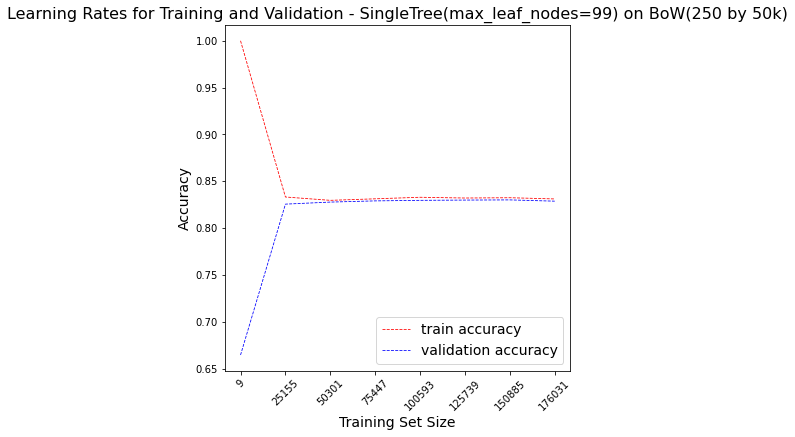

In [21]:
plot_learning_curves_feed_m(tree_clf, X_train_transformed, y_array, 
                           'SingleTree(max_leaf_nodes=99) on BoW(250 by 50k)')

The model appears to have converged on its best accuracy after only a fraction of the training data so adding more data will not be helpful. Another parameter we might consider tweaking a bit is `max_features`, since default of **None** means `n_features` and we know we have a lot of features.

In [22]:
params = {'max_leaf_nodes': [99], 
          'max_features': list(range(1000,51000,2000))}

tree_clf = DecisionTreeClassifier(random_state=42)

grid_search_cv = GridSearchCV(tree_clf, params, n_jobs=-1, verbose=2, cv=3)
grid_search_cv

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_features': [1000, 3000, 5000, 7000, 9000, 11000,
                                          13000, 15000, 17000, 19000, 21000,
                                          23000, 25000, 27000, 29000, 31000,
                                          33000, 35000, 37000, 39000, 41000,
                                          43000, 45000, 47000, 49000],
                         'max_leaf_nodes': [99]},
             verbose=2)

In [23]:
# train 
grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 14.9min finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_features': [1000, 3000, 5000, 7000, 9000, 11000,
                                          13000, 15000, 17000, 19000, 21000,
                                          23000, 25000, 27000, 29000, 31000,
                                          33000, 35000, 37000, 39000, 41000,
                                          43000, 45000, 47000, 49000],
                         'max_leaf_nodes': [99]},
             verbose=2)

In [24]:
grid_search_cv.best_params_

{'max_features': 11000, 'max_leaf_nodes': 99}

In [25]:
for i,v in enumerate(grid_search_cv.cv_results_['mean_test_score']):
    if v == max(grid_search_cv.cv_results_['mean_test_score']):
        print('Max mean test accuracy:', round(v,4), \
              '\nParams:', grid_search_cv.cv_results_['params'][i])

Max mean test accuracy: 0.6925 
Params: {'max_features': 11000, 'max_leaf_nodes': 99}


In [27]:
tree_clf = DecisionTreeClassifier(random_state=42, max_leaf_nodes=99, max_features=11000)

# cross validation on entire training data for a more robust result
scores = cross_val_score(tree_clf, X_train_transformed, y_array, cv=5, verbose=2, scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  17.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s remaining:    0.0s


[CV] ................................................. , total=  27.4s
[CV]  ................................................................
[CV] ................................................. , total=  31.0s
[CV]  ................................................................
[CV] ................................................. , total=  34.3s
[CV]  ................................................................
[CV] ................................................. , total=  33.5s
Accuracy: 0.6832 (+/- 0.01)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min finished


### Save grid search results

While there's no need per se, it's always good to have more data - later I could decide to plot these results to understand more facets of the learning process.

In [28]:
from joblib import dump, load

model_dir = os.path.join("..","data","4_models","sentiment140")

In [24]:
# save the 3-hour grid search
file_path = os.path.join(model_dir, "20201024_DecisionTree_GridSearchCV.joblib")
dump(grid_search_cv, file_path)

['..\\data\\4_models\\sentiment140\\20201024_DecisionTree_GridSearchCV.joblib']

In [29]:
# save the 15-minute grid search 
# note: different run of the same notebook skipping the 3-hour grid search
file_path = os.path.join(model_dir, "20201024_DecisionTree_GridSearchCV2.joblib")
dump(grid_search_cv, file_path)

['..\\data\\4_models\\sentiment140\\20201024_DecisionTree_GridSearchCV2.joblib']

---